In [1]:
%load_ext autoreload

In [2]:
from __future__ import division

import numpy as np
from envs import MarsExplorerEnv
import matplotlib.pyplot as plt
import time
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib._png import read_png
import pickle as pkl
%matplotlib inline

import gym
from gym import spaces
# from gym.envs.classic_control import rendering
import tensorflow as tf
from scipy.special import logsumexp
from copy import deepcopy as copy
import random
np.set_printoptions(precision=8, suppress=True,threshold=np.nan)


import types
import uuid
import math
import tensorflow as tf
from scipy.misc import logsumexp
# from baselines import deepq
# import baselines.common.tf_util as U

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [4]:
%autoreload

In [5]:
def save_tf_vars(sess, scope, path):
  saver = tf.train.Saver([v for v in tf.global_variables() if v.name.startswith(scope + '/')])
  saver.save(sess, save_path=path)

def load_tf_vars(sess, scope, path):
  saver = tf.train.Saver([v for v in tf.global_variables() if v.name.startswith(scope + '/')])
  saver.restore(sess, path)

In [6]:
data_dir = os.path.join('data', '1.2')

# Environment Setup

In [7]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
NOOP = 4

cdict = {'red':   ((0.0,  0.173, 0.173),
                   (1.0,  0.925, 0.925)),

         'green': ((0.0,  0.067, 0.067),
                   (1.0, 0.384, 0.384)),

         'blue':  ((0.0,  0.027, 0.027),
                   (1.0,  0.196, 0.196))}
plt.register_cmap(name='RustPlanet', data=cdict)
REWARD_COLORS = cm.get_cmap('RustPlanet')
AGENT_COLORS = cm.get_cmap('gray')
MAP_COLORS = {b'B':"#3a0e00",
              b'F':"#933111",
              b'S':"#933111",
              b'U':"#d65b33",
              b'1':"#956F52",
              b'2':"#3C2F34",
              b'3':"#644C42"}

ROVER_PNGS = {LEFT:"utils/rover_left.png",
        RIGHT:"utils/rover_right.png",
        DOWN:"utils/rover_down.png",
        UP:"utils/rover_up.png",
        NOOP:"utils/rover_sample.png"}

# tile_map = [
#         "F3FFUFU2U",
#         "FUFUSUFUF",
#         "FFFUSUFFU",
#         "USUUUUUSU",
#         "FFUSSSUFF",
#         "FSFUSUFSF",
#         "UUUUUUUFU",
#         "UFFU1UFUU",
#         "3UUFUFFU1"
#     ]

# tile_map = [
#         "F22222FF1",
#         "U31122FU1",
#         "UF1112FU1",
#         "UFUU1SFU1",
#         "UFFU1FFU3",
#         "3222UFS1U",
#         "UUU22F1FU",
#         "FSSFS12SF",
#         "FSFF121FF",
#         "S1S2SFFSF",
#         "FUUUFFSFU",
#         "U3UUUFSFU",
#         "FFFUUFUUU"
#     ]

# tile_map = [
#         "2FFFUFFF1",
#         "FFFU3UFFF",
#         "FFFFUFFFF",
#         "FSFUUUFSF",
#         "FSUUSUUSF",
#         "FSFUUUFSF",
#         "FFFFUFFFF",
#         "FFFSSSFFF",
#         "1FFFFFFF2"
#     ]

tile_map = [
        "2FFFUFFF1",
        "FFFUUUFFF",
        "FFFFUFFFF",
        "FSFUUUFSF",
        "FSUU3UUSF",
        "FSFUUUFSF",
        "FFFFUFFFF",
        "FFFSSSFFF",
        "1FFFFFFF2"
    ]

tile_rewards = {'F':0.05,
              '1':0.1,
              '2':0.1,
              '3':0.1,
              'S':0.01,
              'U':0.0}


goal_tile_rewards = {'F':0.0,
              '1':1.0,
              '2':2.0,
              '3':8.0,
              'S':0.0,
              'U':0.0}


# Enables "texturizing" the environment such that certain areas
# will have greater reward despite being the same tile types
tile_reward_modifier = lambda r,x,y,mx,my: r #* 0.1 * ((x-(mx/2 + np.random.normal(scale=0.5)))**2 + (y - (mx/2 + np.random.normal(scale=0.5)))**2)

def build_reward_map(tile_map, tile_rewards, goal_tile_rewards, tile_reward_modifier):
    reward_map = np.zeros((len(tile_map),len(tile_map[0])))
    texture_map = np.zeros((len(tile_map),len(tile_map[0])))
    for y,row in enumerate(tile_map):
        for x,c in enumerate(row):
            reward_map[y,x] = texture_map[y,x] = tile_reward_modifier(tile_rewards[c],x,y,len(tile_map[0]),len(tile_map))
            reward_map[y,x] +=  goal_tile_rewards[c]
    return reward_map, texture_map

reward_map, texture_map = build_reward_map(tile_map, tile_rewards, goal_tile_rewards, tile_reward_modifier)


t0 = (0.8,0.1,0.0,0.0)
t1 = (0.001,0.0,0.0,0.999)  #(0.1,0.15,0.5,0.1)

trans_dict = {b'F':t0,
              b'1':t0,
              b'2':t0,
              b'3':t0,
              b'S':t0,
              b'U':t1}

#TODO implement theta_mat in mars_explorer so do not need to hard code, use np.roll
true_tps = np.array([[[0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.0, 1.]],

 [[0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.0, 1.]],

 [[0., 0.],
  [0., 0.],
  [0., 0.],
  [0., 0.],
  [1., 1.]]])

true_tps = np.array([[[0.8, 0.001],
  [0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.0, 0.999]],

 [[0.1, 0.],
  [0.8, 0.001],
  [0.1, 0.],
  [0.0, 0.],
  [0.0, 0.999]],

 [[0.0, 0.],
  [0.1, 0.],
  [0.8, 0.001],
  [0.1, 0.],
  [0.0, 0.999]],

 [[0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.8, 0.001],
  [0.0, 0.999]],

 [[0., 0.],
  [0., 0.],
  [0., 0.],
  [0., 0.],
  [1., 1.]]])

gamma = 0.95

T_theta_shape = (5,5,2)

time_penalty = 0.0


In [8]:
mdp = MarsExplorerEnv(tile_map, reward_map, texture_map, trans_dict, time_penalty) 
nA = mdp.nA
nS = mdp.nS

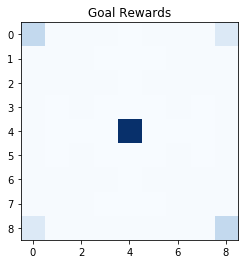

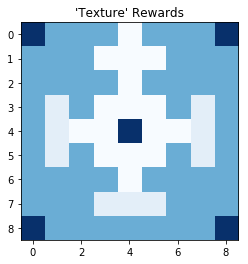

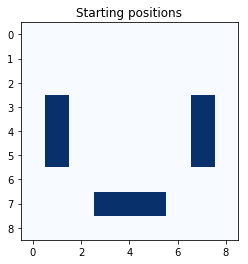

In [9]:
plt.imshow(reward_map, cmap="Blues")
plt.title("Goal Rewards")
plt.show()
plt.imshow(texture_map, cmap="Blues")
plt.title("'Texture' Rewards")
plt.show()

binary_map = np.ones(mdp.tile_map.shape)
binary_map[np.where(mdp.tile_map == b'S')] = 255.0
plt.imshow(binary_map, cmap="Blues")
plt.title("Starting positions")
plt.show()

# Demo visualization tools

In [10]:
def plot_mars(mdp, pi, term = 40, title=None, counts = None, Qs = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    s = mdp._reset()
    t, r = 0, 0
    while s is not None and t < term:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        a = pi[s] if type(pi) == np.ndarray else pi(s)
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}      r: {}'.format(t,round(r,4)), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        if Qs is not None:
            print(Qs[s])
            print(a)
            print(softmax(Qs[s]))
        print(mdp.s_to_grid(s), mdp.tile_map.flatten()[s])
        s, rt, _, d = mdp._step(a)
        print(mdp.s_to_grid(s), mdp.tile_map.flatten()[s])
        t += 1
        r += rt
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_mars_history(mdp, hist, title=None, counts = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    t = 0
    for s,a,sprime in [h[0] for h in hist]:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}'.format(t), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        t += 1
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_values(mdp, Qs, s=None, title=None):
    V = np.max(Qs, axis=1).reshape((mdp.nrow,mdp.ncol))
    pi = np.argmax(Qs, axis=1)
    plt.figure(figsize=(8,8))
    if title != None:
        plt.title(title)
    plt.imshow(V, cmap='gray')#, clim=(0,1)) 'gist_ncar'
    ax = plt.gca()
    ax.set_xticks(np.arange(V.shape[1])-.5)
    ax.set_yticks(np.arange(V.shape[0])-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:V.shape[0], 0:V.shape[1]]
    a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(0, 1), 4:(-1,-1)}
    Pi = pi.reshape(V.shape)
    for y in range(V.shape[0]):
        for x in range(V.shape[1]):
            a = Pi[y, x]
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.2, head_length=0.1) 
            plt.text(x, y, str(mdp.tile_map[y,x].item().decode()),
                     color='c', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
    if s != None:
        plt.plot(s%V.shape[0], s//V.shape[0], 'ro')
#     plt.grid(color='b', lw=2, ls='-')
    return

# Soft-Q Learning for Demonstrations

In [11]:
def softmax(x, axis=1):
    """Compute softmax values for each sets of scores in x."""
    axis = 0 if len(x.shape) == 1 else axis
    e_x = np.exp(x - np.max(x, axis=axis,keepdims=True))
    return (e_x / e_x.sum(axis=axis, keepdims = True))

In [12]:
def tabsoftq_iter(R, T, maxiter=10000, verbose=False, Q_init=None, learning_rate=0.5, ftol=1e-32):
    Q = np.zeros((nS, nA)) if Q_init is None else copy(Q_init)
    prevQ = copy(Q)
    if verbose:
        diffs = []
        meanVs = []
    for iter_idx in range(maxiter):
        V = logsumexp(prevQ, axis=1)
        V_broad = V.reshape((1, 1, nS))
        Q = R + gamma * np.sum(T * V_broad, axis=2)
        Q = (1 - learning_rate) * prevQ + learning_rate * Q
        diff = np.mean((Q - prevQ)**2)/(np.std(Q)**2)
        if verbose:
            diffs.append(diff)
            meanVs.append(np.mean(V)) 
        if diff < ftol:
            break
        prevQ = copy(Q)
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Value of All Tiles')
        plt.title('Soft Q Iteration')
        plt.plot(meanVs)
        plt.show()
    return Q

In [13]:
def tabsoftq_learn_Qs(mdp):
    R = np.repeat(mdp.rewards[np.newaxis].T, 5, axis=1)
    T = mdp.get_transition_matrix()
    Qs = tabsoftq_iter(R, T)
    return Qs

def tabsoftq_gen_pol(Qs, beta=1):
    softQs = softmax(Qs * beta)
    return lambda s: np.random.choice(np.asarray(range(len(Qs[s]))),p=softQs[s])

def tabsoftq_gen_pol_probs(Qs, beta=1):
    softQs = softmax(Qs * beta)
    return softQs


In [14]:
def generate_demonstrations(mdp, pol, n, term):
    hists = []
    for i in range(n):
        s, d, t = mdp._reset(), False, 0
        hist = []
        while not d and t < term:
            a = pol[s] if type(pol) == np.ndarray else pol(s)
            sprime, rt, _, ob_dict = mdp._step(a)
            hist += [((s,a,sprime),ob_dict['adt'])]
            t += 1
            s = sprime
        hists += [hist]
    return hists

In [15]:
def vectorize_rollouts(rollouts):
    sas_obs = []
    adt_obs = []
    task_idxes = []
    for rollout in rollouts:
        more_sas, more_adt = list(zip(*rollout))
        sas_obs.extend(more_sas)
        adt_obs.extend(more_adt)
    return np.array(sas_obs), np.array(adt_obs)

Sanity check (env and softq)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


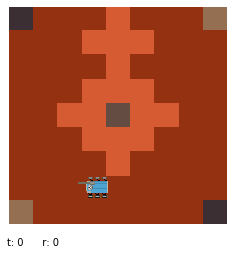

[42.51647045 41.68794848 39.33647824 39.37253894 40.91782063]
0
[0.58019364 0.25336723 0.02412792 0.02501387 0.11729734]
(3, 7) b'S'
(2, 7) b'F'


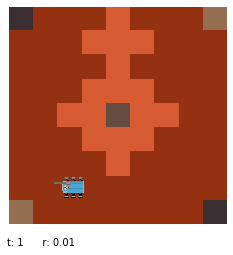

[44.67009291 44.13379464 41.34869765 41.7392116  43.08604636]
0
[0.53205494 0.31120395 0.01920847 0.02838513 0.1091475 ]
(2, 7) b'F'
(2, 6) b'F'


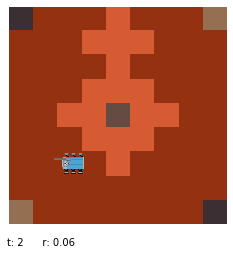

[42.69224983 42.67792627 39.40519379 39.43917283 41.41559133]
0
[0.42721072 0.42113516 0.01596217 0.01651387 0.11917809]
(2, 6) b'F'
(1, 6) b'F'


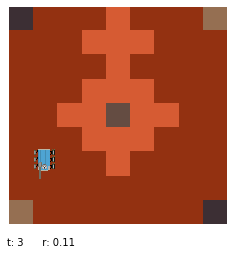

[44.16402319 44.67233866 41.75147414 41.44904371 43.09985592]
1
[0.31612593 0.52555567 0.02832066 0.02092953 0.1090682 ]
(1, 6) b'F'
(1, 7) b'F'


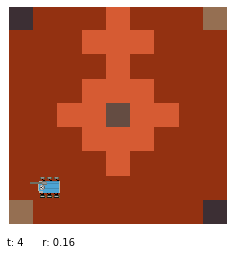

[46.59219686 46.5898783  43.47672709 43.48652773 45.1095647 ]
0
[0.43217535 0.43117448 0.01917029 0.01935909 0.09812079]
(1, 7) b'F'
(1, 8) b'F'


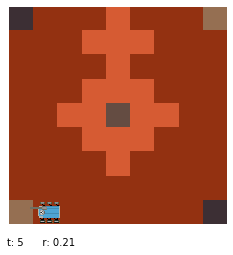

[49.09502616 47.45265367 44.7921412  45.50727641 46.97904413]
0
[0.73788473 0.14279573 0.00998319 0.02041026 0.08892609]
(1, 8) b'F'
(0, 8) b'1'


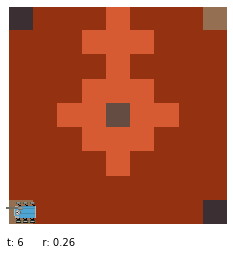

[51.36456163 51.36399322 48.39972108 48.40072075 50.83742633]
0
[0.37134491 0.37113389 0.01914977 0.01916892 0.21920251]
(0, 8) b'1'
(8, 8) b'2'


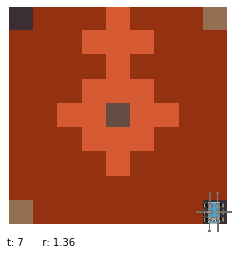

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


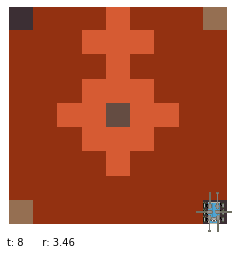

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


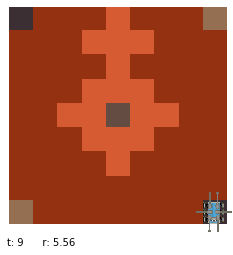

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


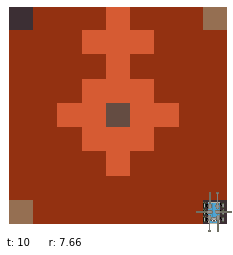

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


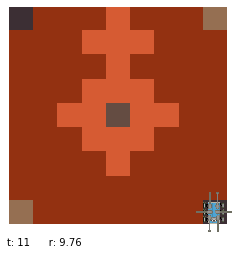

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


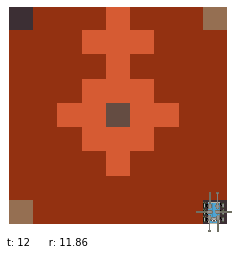

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


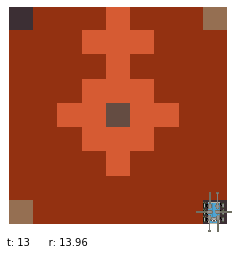

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


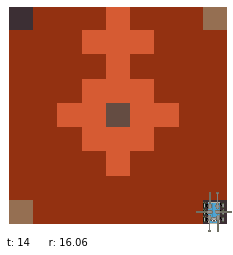

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


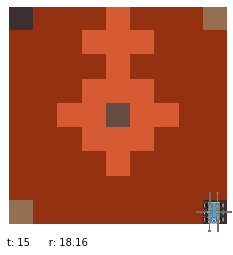

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


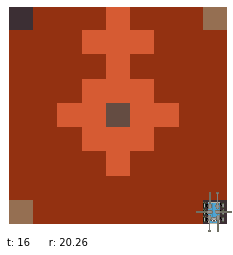

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


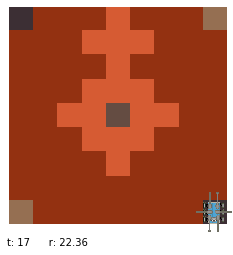

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


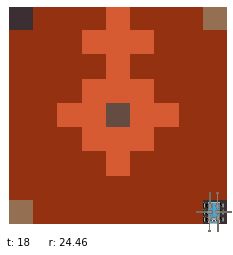

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


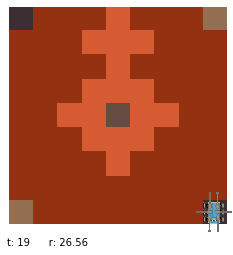

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


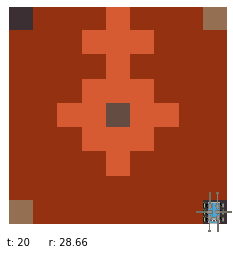

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


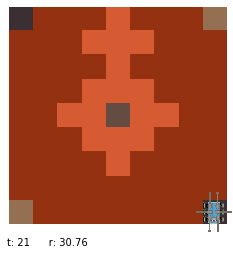

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


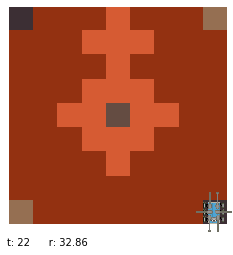

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


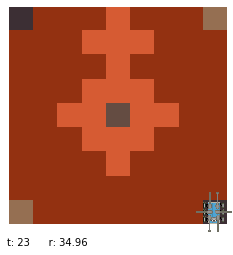

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


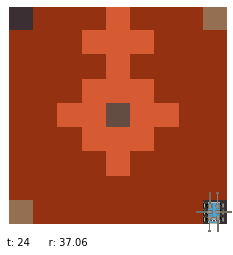

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


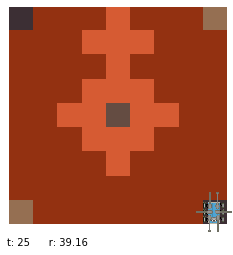

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


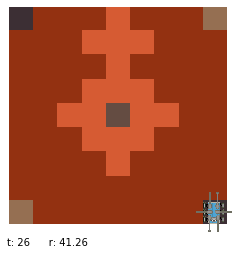

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


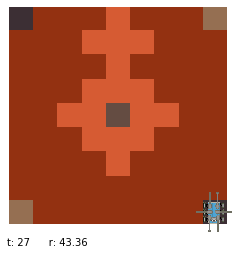

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


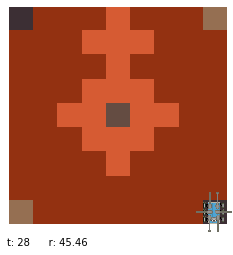

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


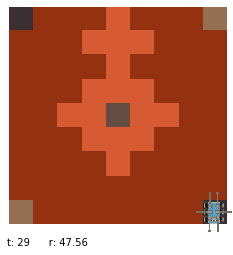

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


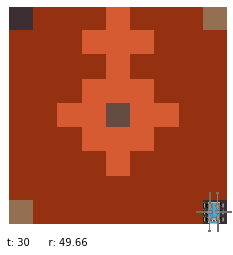

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


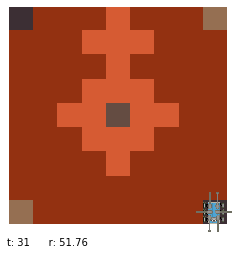

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


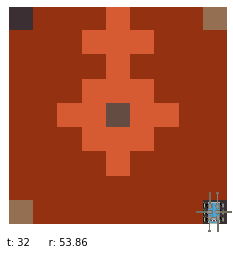

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


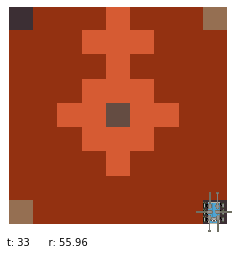

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


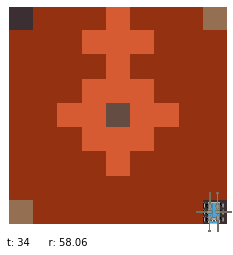

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


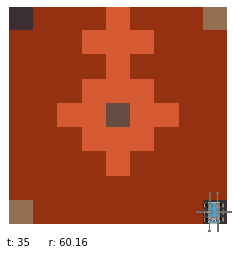

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


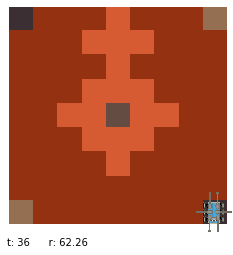

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


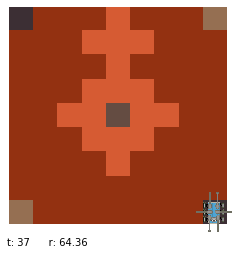

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


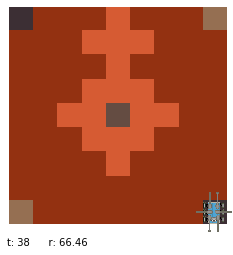

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


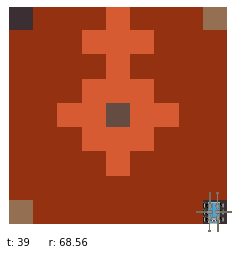

[49.81868836 51.61275242 51.61315923 49.81934571 52.73509482]
4
[0.03076396 0.18500963 0.18508491 0.03078419 0.56835731]
(8, 8) b'2'
(8, 8) b'2'


In [16]:
Q = tabsoftq_learn_Qs(mdp)
plot_mars(mdp,tabsoftq_gen_pol(Q*50),Qs=Q)


# Model Set Up

In [17]:
train_demo_example_idxes = None
val_demo_example_idxes = None

gamma = 0.99
iterations = 100000
alpha = 1e-4
beta1 = 0.9
beta2 = 0.999999
batch_size = 512
sq_td_err_penalty = 4
trans_err_penalty = 1


q_n_layers = 2
q_layer_size = 2048
q_activation = tf.nn.tanh
q_output_activation = None

invdyn_n_layers = 1
invdyn_layer_size = 256
invdyn_activation = tf.nn.relu
invdyn_output_activation = None


constraint_sampling_freq = 100000
constraint_batch_size = batch_size
n_constraint_rollouts_per_env = 100

val_update_freq = 1

In [18]:
n_obs_feats = 2
n_act_dim = 5
featurize_states = lambda states: np.array([mdp.s_to_grid(state) for state in states])
featurize_acts = lambda a: a
n_dirs = 5

In [19]:
def build_mlp(
    input_placeholder,
    output_size,
    scope,
    n_layers=1,
    size=256,
    activation=tf.nn.relu,
    output_activation=None,
    reuse=False
      ):
    out = tf.cast(input_placeholder, tf.float32)
    with tf.variable_scope(scope, reuse=reuse):
        for _ in range(n_layers):
            out = tf.layers.dense(out, size, activation=activation)
        out = tf.layers.dense(out, output_size, activation=output_activation)
    return out

In [20]:
def nn_vectorize_rollouts(sas_obs, adt_obs):
    states, acts, next_states = zip(*sas_obs)
    _, dirs, tiles = zip(*adt_obs)
    states_feats = featurize_states(states)
    states = np.expand_dims(np.array(states), axis=1)
    actions = np.expand_dims(np.array(acts), axis=1)
    next_states_feats = featurize_states(next_states)
    next_states = np.expand_dims(np.array(next_states), axis=1)
    dirs = np.expand_dims(np.array(dirs), axis=1)
    tiles = np.expand_dims(np.array(tiles), axis=1)
    return (states, states_feats, actions, next_states, next_states_feats, dirs, tiles)

def get_rollout_indexes(sas_obs):
    demo_example_idxes = list(range(len(sas_obs)))
    random.shuffle(demo_example_idxes)
    n_train_demo_examples = int(0.9 * len(demo_example_idxes))
    train_demo_example_idxes = demo_example_idxes[:n_train_demo_examples]
    val_demo_example_idxes = demo_example_idxes[n_train_demo_examples:]
    return (train_demo_example_idxes, val_demo_example_idxes)

def sample_batch(rollouts, indexes, size=None):
    idxes = random.sample(indexes, size) if size is not None else indexes
    demo_batch = [comp[idxes] for comp in rollouts]
    return demo_batch

def generate_constraints(mdp):
    s = np.arange(mdp.nS)
    a = np.arange(mdp.nA) 
    sa = np.transpose([np.tile(s, len(a)), np.repeat(a, len(s))])
    states, acts = sa[:,0], sa[:,1]
    feat_states = featurize_states(states)
    tiles = np.expand_dims(np.array([mdp.get_tile_type(s) for s in states]), axis=1)
    acts_array = np.expand_dims(acts,axis=1)
    rewards = np.array([mdp.get_reward(states[i], acts[i]) for i in range(len(states))])
    sprimes = mdp.get_possible_sprimes(feat_states)

    return feat_states, acts_array, rewards, sprimes, tiles

In [21]:
###### UNCOMMENT WHEN FIRST RUNNING THIS NOTEBOOK #######

# im_scope =  str(uuid.uuid4())
# q_scope = str(uuid.uuid4())
# invsas_scope = str(uuid.uuid4())
# invadt_scope = str(uuid.uuid4())

# with open(os.path.join(data_dir, 'im_scope.pkl'), 'wb') as f:
#     pkl.dump(im_scope, f)

# with open(os.path.join(data_dir, 'q_scope.pkl'), 'wb') as f:
#     pkl.dump(q_scope, f)

# with open(os.path.join(data_dir, 'invsas_scope.pkl'), 'wb') as f:
#     pkl.dump(invsas_scope, f)
    
# with open(os.path.join(data_dir, 'invadt_scope.pkl'), 'wb') as f:
#     pkl.dump(invadt_scope, f)

In [22]:
with open(os.path.join(data_dir, 'im_scope.pkl'), 'rb') as f:
    im_scope = pkl.load(f)

with open(os.path.join(data_dir, 'q_scope.pkl'), 'rb') as f:
    q_scope = pkl.load(f)

with open(os.path.join(data_dir, 'invsas_scope.pkl'), 'rb') as f:
    invsas_scope = pkl.load(f)
    
with open(os.path.join(data_dir, 'invadt_scope.pkl'), 'rb') as f:
    invadt_scope = pkl.load(f)

In [23]:
sess = tf.Session()

In [24]:
# Demo placeholders are for the action-likelihood and transition-likelihood portions of the loss
# Constraint placeholders are for the bellman-residual penalty

demo_obs_t_ph = tf.placeholder(tf.int32, [None,1], name="dot")
demo_tile_t_ph = tf.placeholder(tf.int32, [None, 1], name="dtt")
demo_act_t_ph = tf.placeholder(tf.int32, [None, 1], name="dat")
demo_next_obs_t_ph = tf.placeholder(tf.int32, [None,1], name="dnot")
demo_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_obs_feats], name="dotf")
demo_next_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_obs_feats], name="dnotf")
demo_dir_t_ph = tf.placeholder(tf.int32, [None, 1], name="ddt")
demo_batch_size_ph = tf.placeholder(tf.int32, name="dbs")

constraint_obs_t_ph = tf.placeholder(tf.int32, [None,1], name="cot")
constraint_tile_t_ph = tf.placeholder(tf.int32, [None, 1], name="ctt")
constraint_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_obs_feats], name="cotf")
constraint_act_t_ph = tf.placeholder(tf.int32, [None, 1], name="cat")
constraint_rew_t_ph = tf.placeholder(tf.float32, [None], name="crt")
constraint_next_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_dirs, n_obs_feats], name="cnotf")
constraint_batch_size_ph = tf.placeholder(tf.int32, name="cbs")

In [25]:
# Boltz-beta determines the "rationality" of the agent being modeled. 
# Setting it to higher values corresponds to "pure rationality"
boltz_beta = 50

demo_q_t = build_mlp(demo_obs_t_feats_ph,
    n_act_dim, q_scope, 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation) * boltz_beta

demo_v_t = tf.reduce_logsumexp(demo_q_t, axis=1)

In [26]:
action_indexes = tf.concat([tf.expand_dims(tf.range(demo_batch_size_ph), 1), demo_act_t_ph], axis=1)

act_log_likelihoods = tf.gather_nd(demo_q_t, action_indexes) - demo_v_t

neg_avg_act_log_likelihood = -tf.reduce_mean(act_log_likelihoods)

In [27]:
# Encoded the potential to use "sas" transitions, which are simply state, action, state observations,
# and "adt" transitions -- post-processed to determine (a)ction taken, (d)irection moved, and starting (t)ile-type
# Learning an "adt" transition model should be much easier

sas_pred_obs = build_mlp(
  tf.concat((demo_obs_t_feats_ph, demo_act_t_ph), axis=1),
  n_dirs, invsas_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation)

adt_pred_dir = build_mlp(
  tf.concat((demo_act_t_ph, demo_tile_t_ph), axis=1),
  n_dirs, invadt_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation)

dir_indexes = tf.concat([tf.expand_dims(tf.range(demo_batch_size_ph), 1), demo_dir_t_ph], axis=1)

adt_log_likelihoods = tf.gather_nd(adt_pred_dir, dir_indexes) - tf.reduce_logsumexp(adt_pred_dir, axis=1)

neg_avg_adt_log_likelihood = -tf.reduce_mean(adt_log_likelihoods)

sas_log_likelihoods = tf.gather_nd(sas_pred_obs, dir_indexes) - tf.reduce_logsumexp(sas_pred_obs, axis=1)

neg_avg_sas_log_likelihood = -tf.reduce_mean(sas_log_likelihoods)

In [28]:
ca_indexes = tf.concat([tf.expand_dims(tf.range(constraint_batch_size_ph), 1), constraint_act_t_ph], axis=1)

constraint_q_ts = build_mlp(constraint_obs_t_feats_ph,
        n_act_dim, q_scope, 
        n_layers=q_n_layers, size=q_layer_size,
        activation=q_activation, output_activation=q_output_activation,
        reuse=True)

constraint_q_t = tf.gather_nd(constraint_q_ts, ca_indexes)


# Predicted constraint next state given inv dyns
constraint_sas_pred_obs = build_mlp(
  tf.concat((constraint_obs_t_feats_ph, constraint_act_t_ph), axis=1),
  n_dirs, invsas_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation,
  reuse=True)

constraint_adt_pred_dir = build_mlp(
  tf.concat((constraint_act_t_ph, constraint_tile_t_ph), axis=1),
  n_dirs, invadt_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation,
  reuse=True)

In [29]:
constraint_sprimes_reshaped = tf.reshape(constraint_next_obs_t_feats_ph, (constraint_batch_size_ph * n_dirs, n_obs_feats))

In [30]:
# Q-values used to calculate 'V' in the bellman-residual
cqtp1_misshaped = build_mlp(constraint_sprimes_reshaped,
    n_act_dim, q_scope, 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation,
    reuse=True)

constraint_q_tp1 = tf.reshape(cqtp1_misshaped, (constraint_batch_size_ph, n_dirs, n_act_dim))

constraint_v_tp1 = tf.reduce_logsumexp(constraint_q_tp1, axis=2) 

In [31]:
# sas bellman residual penalty error
constraint_sas_pred_probs = tf.nn.softmax(constraint_sas_pred_obs, axis=1)
sas_V = tf.multiply(constraint_v_tp1, constraint_sas_pred_probs)
sas_target_t = constraint_rew_t_ph + gamma * tf.reduce_sum(sas_V, axis=1)
sas_td_err = tf.reduce_mean((constraint_q_t - sas_target_t)**2)


# adt bellman residual penalty error
constraint_adt_pred_probs = tf.nn.softmax(constraint_adt_pred_dir, axis=1)
adt_V = tf.multiply(constraint_v_tp1, constraint_adt_pred_probs)
adt_target_t = constraint_rew_t_ph + gamma * tf.reduce_sum(adt_V, axis=1)
adt_td_err = tf.reduce_mean((constraint_q_t - adt_target_t)**2)

In [32]:
# sas and adt bellman residual penalty error with a stop gradient on transitions to prevent the bellman update from
# 'hacking' the transition function to overly explain the demonstrations. This happens a lot early on before the
# Q-values have obtained much meaning

sas_V_sg = tf.multiply(constraint_v_tp1, tf.stop_gradient(constraint_sas_pred_probs))
sas_target_sg = constraint_rew_t_ph + gamma * tf.reduce_sum(sas_V_sg, axis=1)
sas_td_err_sg = tf.reduce_mean((constraint_q_t - sas_target_sg)**2)

adt_V_sg = tf.multiply(constraint_v_tp1, tf.stop_gradient(constraint_adt_pred_probs))
adt_target_sg = constraint_rew_t_ph + gamma * tf.reduce_sum(adt_V_sg, axis=1)
adt_td_err_sg = tf.reduce_mean((constraint_q_t - adt_target_sg)**2)

In [33]:
# Total loss function for the sas formulation
sas_loss = neg_avg_act_log_likelihood + trans_err_penalty * neg_avg_sas_log_likelihood + sq_td_err_penalty * sas_td_err

# Total loss function for the adt formulation
adt_loss = neg_avg_act_log_likelihood + trans_err_penalty * neg_avg_adt_log_likelihood + sq_td_err_penalty * adt_td_err

# Loss function for the adt formulation that only optimizes over the q-value approximation 
adt_loss_act_only = neg_avg_act_log_likelihood + sq_td_err_penalty * adt_td_err_sg

# Total loss function for the adt formulation with a stop-gradient on the transition function for the bellman residual
adt_brsgt_loss = neg_avg_act_log_likelihood + trans_err_penalty * neg_avg_adt_log_likelihood + sq_td_err_penalty * adt_td_err_sg

In [34]:
sas_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(sas_loss)

adt_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(adt_loss)

adt_brsgt_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(adt_brsgt_loss)

adt_trans_only_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(neg_avg_adt_log_likelihood)

adt_q_br_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(adt_td_err_sg)

q_nll_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(neg_avg_act_log_likelihood)

In [36]:
# Uncertainty weighted loss function motivated by https://arxiv.org/pdf/1705.07115.pdf

sigma_a, sigma_t, sigma_br = tf.Variable(0.0), tf.Variable(0.0), tf.Variable(0.0)

# Simple sum is sufficient so long as all losses use means
sigma_log_losses = sigma_a + sigma_t # + sigma_br

weighted_na_act_ll = tf.exp(-sigma_a) * neg_avg_act_log_likelihood

weighted_na_adt_ll = tf.exp(-sigma_t) * neg_avg_adt_log_likelihood

weighted_na_br = (adt_td_err * sq_td_err_penalty + adt_td_err_sg * 3 * sq_td_err_penalty) / 4 #tf.exp(-sigma_br) * 

adt_uncertainty_loss = weighted_na_act_ll + weighted_na_adt_ll + weighted_na_br + sigma_log_losses

adt_un_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(adt_uncertainty_loss)

In [37]:
# Add in ability to train the q-fn approximator on the true values to test model capacity
true_qs_ph = tf.placeholder(tf.float32, [None], name="tq")
true_q_errs = constraint_q_t - true_qs_ph
true_q_err = tf.reduce_sum((true_q_errs)**2)
true_q_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(true_q_err)

In [38]:
def compute_batch_loss(demo_batch, constraints, step=False, update="adt", t=None, true_qs=None):
    feed_dict = {
        demo_obs_t_feats_ph: demo_batch[1],
        demo_act_t_ph: demo_batch[2],
        demo_next_obs_t_feats_ph: demo_batch[4],
        demo_dir_t_ph: demo_batch[5],
        demo_tile_t_ph: demo_batch[6],
        demo_batch_size_ph: demo_batch[2].shape[0],
        constraint_obs_t_feats_ph: constraints[0],
        constraint_act_t_ph: constraints[1],
        constraint_rew_t_ph: constraints[2],
        constraint_next_obs_t_feats_ph: constraints[3],
        constraint_tile_t_ph: constraints[4],
        constraint_batch_size_ph: constraints[0].shape[0]
    }
      
    # Naive case of only optimizing over observed transitions -- useful to initialize the dynamics model
    if update == "trans": 
        [trans_likelihood_eval] = sess.run([neg_avg_adt_log_likelihood], feed_dict=feed_dict)
        update_op = adt_trans_only_update_op
        if step:
            sess.run(update_op, feed_dict=feed_dict)
        d = {'loss':trans_likelihood_eval}
    
    # Optimization over the full adt loss function
    if update == "adt":
        [loss_eval, act_likelihood_eval, td_err_eval, trans_likelihood_eval] = sess.run(
            [adt_loss, neg_avg_act_log_likelihood, adt_td_err, neg_avg_adt_log_likelihood], feed_dict=feed_dict)
        update_op = adt_update_op
        d = {'loss': loss_eval,
            'nall': act_likelihood_eval,
            'tde': td_err_eval,
            'ntll': trans_likelihood_eval}
    
    # Optimization over the adt uncertainty-weighted loss function
    if update == "adt_un":
        [loss_eval, act_likelihood_eval, td_err_eval, trans_likelihood_eval, sig_a, sig_t, sig_br] = sess.run(
            [adt_uncertainty_loss, neg_avg_act_log_likelihood, adt_td_err, neg_avg_adt_log_likelihood,
                 sigma_a, sigma_t, sigma_br], feed_dict=feed_dict)
        update_op = adt_un_update_op
        d = {'loss': loss_eval,
            'nall': act_likelihood_eval,
            'tde': td_err_eval,
            'ntll': trans_likelihood_eval,
            'sigmas': (sig_a, sig_t, sig_br)}
        
    # Optimizing only the q-fn over the bellman residual, equivalent to soft Q-learning
    if update == "adt_br":
        [loss_eval] = sess.run([adt_td_err_sg], feed_dict=feed_dict)
        update_op = adt_q_br_update_op
        d = {'loss': loss_eval}
    
    # Optimization over the full adt loss function with a stop gradient on the dynamics model for the bellman residual
    # Useful in getting the q-fn to match both the observed dynamics and the observed actions taken
    if update == "adt_brsgt":
        [loss_eval, act_likelihood_eval, td_err_eval, trans_likelihood_eval] = sess.run(
            [adt_loss, neg_avg_act_log_likelihood, adt_td_err_sg, neg_avg_adt_log_likelihood], feed_dict=feed_dict)
        update_op = adt_brsgt_update_op
        d = {'loss': loss_eval,
            'nall': act_likelihood_eval,
            'tde': td_err_eval,
            'ntll': trans_likelihood_eval}
        
    # Optimization over the full sas loss function
    if update == "sas":
        [loss_eval, act_likelihood_eval, td_err_eval, trans_likelihood_eval] = sess.run(
            [sas_loss, neg_avg_act_log_likelihood, sas_td_err, neg_avg_sas_log_likelihood], feed_dict=feed_dict)
        update_op = sas_update_op
        d = {'loss': loss_eval,
            'nall': act_likelihood_eval,
            'tde': td_err_eval,
            'ntll': trans_likelihood_eval}
    
    # For debugging and testing model capacity
    if update == "true_qs":
        feed_dict[true_qs_ph] = true_qs
        [loss_eval] = sess.run([true_q_err], feed_dict=feed_dict)
        update_op = true_q_update_op
        d = {'loss': loss_eval}
 
    if step:
        sess.run(update_op, feed_dict=feed_dict)

    return d

# IDL Experiments

## Demo setup

In [39]:
tabsoftq_iter_ftol = 1e-32
tabsoftq_iter_maxiter = 5000
tabsoftq_iter_verbose = False
tabsoftq_grad_iter_ftol = 1e-10
tabsoftq_grad_iter_maxiter = 5000
tabsoftq_grad_iter_verbose = False
batch_size = 200
n_demos = 200
demo_time_steps = 40

In [40]:
def clean_demos(sas_obs, max_noops=15):
    demo_example_idxes = list(range(len(sas_obs)))
    unique_stays, stay_count = set([]), 0
    for i,sas in enumerate(sas_obs):
        sas = tuple(sas)
        if sas[1] == 4:
            stay_count += 1
            if sas in unique_stays:
                if stay_count > max_noops:
                    demo_example_idxes.remove(i)
            else:
                unique_stays.add(sas)
        else:
            stay_count = 0
    return demo_example_idxes

# def sample_batch(size, ids, sas_obs, adt_obs):
#     idxes = random.sample(ids, size)
#     return sas_obs[idxes], adt_obs[idxes]

In [41]:
exQs = tabsoftq_learn_Qs(mdp)
# The rationality constant used to generate demos could certainly vary from the one used in the model.....
temp_boltz_beta = 50
demos = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs * temp_boltz_beta), n_demos, demo_time_steps)
sas_obs, adt_obs = vectorize_rollouts(demos)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  


In [42]:
# Ensure bad areas have not been visited in exes (this is unique to this experiment)
demos = []
while len(demos) < n_demos:
    new_demo = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs, beta=50), 1, demo_time_steps)[0]
    more_sas, more_adt = list(zip(*new_demo))
    if len(set([adt[2] for adt in more_adt])) == 1:
        demos += [new_demo]
        
sas_obs, adt_obs = vectorize_rollouts(demos)

In [43]:
good_indexes = clean_demos(sas_obs)
sas_obs, adt_obs = sas_obs[good_indexes], adt_obs[good_indexes]
constraints = generate_constraints(mdp)
nn_rollouts = nn_vectorize_rollouts(sas_obs, adt_obs)
train_idxes, val_idxes = get_rollout_indexes(sas_obs)
val_demo_batch = sample_batch(nn_rollouts, val_idxes)

In [44]:
# True q-vals for debugging and comparison purposes
Qs = tabsoftq_learn_Qs(mdp)
sa = np.transpose([np.tile(np.arange(mdp.nS), mdp.nA), np.repeat(np.arange(mdp.nA), mdp.nS)])
states, acts = sa[:,0], sa[:,1]
true_qs = Qs[states,acts]

# Preprocessing for training update visualizations
tts = np.arange(2)
acts = np.arange(mdp.nA) 
adt_samples = np.transpose([np.tile(tts, len(acts)), np.repeat(acts, len(tts))])
adt_samples = adt_samples[adt_samples[:,0].argsort()]
states = featurize_states(np.arange(mdp.nS))

# Optional preloading of q-fn or dynamics models
# q_net_path = os.path.join(data_dir, 'true_q_16384.tf')
# save_tf_vars(sess, q_scope, q_net_path)
# load_tf_vars(sess, q_scope, q_net_path)

# invadt_path = os.path.join(data_dir, 'adt_invadt_256.tf')
# load_tf_vars(sess, invadt_scope, invadt_path)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  


## IDL Training

In [45]:
n_training_iters = 1000000

In [46]:
tf.global_variables_initializer().run(session=sess)

In [47]:
full_train_logs = {
  'loss_evals': [],
  'ntll_evals': [],
  'nall_evals': [],
  'tde_evals': [],
  'val_loss_evals': [],
  'val_ntll_evals': [],
  'val_nall_evals': [],
  'val_tde_evals': [],
  'sigmas_evals': []
}

val_log = None

In [48]:
# The best order of optimization seems to be "trans" -> "adt_br" -> "adt_brsgt" -> "adt" [->"adt-br"->"adt"]

# update = "trans"
# update = "adt_br"
# update = "adt_brsgt"
# update = "adt"
update = "adt_un"

[('sigmas', (-2.0961874, -1.6589417, 0.0)), ('ntll', 0.13214716), ('loss', -1.2165349), ('nall', 0.056049667), ('tde', 0.34708926)]


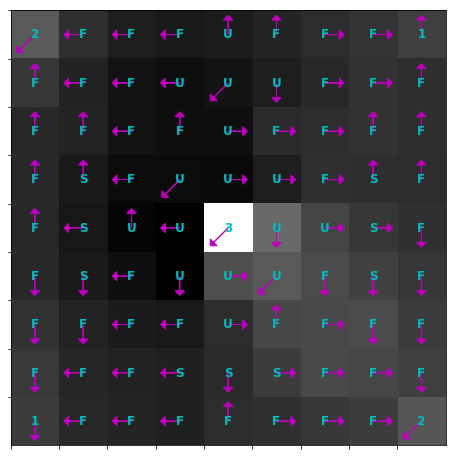

[[0.7846112  0.11443821 0.00002041 0.10093023 0.        ]
 [0.10641867 0.80217487 0.09017774 0.00122882 0.        ]
 [0.00209183 0.1645545  0.7670426  0.06631108 0.        ]
 [0.1047229  0.00002634 0.08553221 0.8096166  0.00010187]
 [0.00000352 0.         0.00000001 0.00000633 0.9999901 ]
 [0.55891335 0.00004011 0.         0.44104654 0.        ]
 [0.5566515  0.00013872 0.00000045 0.44320932 0.        ]
 [0.5325251  0.00000994 0.00208562 0.46537927 0.        ]
 [0.5433435  0.         0.00010518 0.45651126 0.00004012]
 [0.00003159 0.         0.         0.00001006 0.9999584 ]]


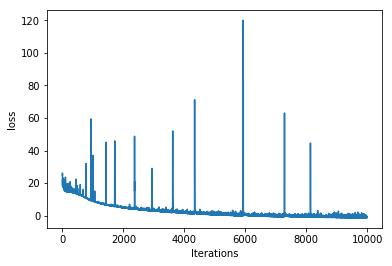

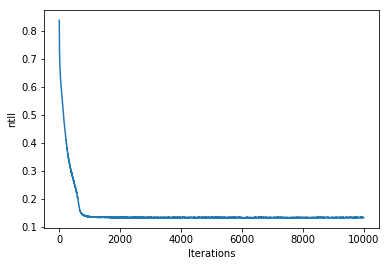

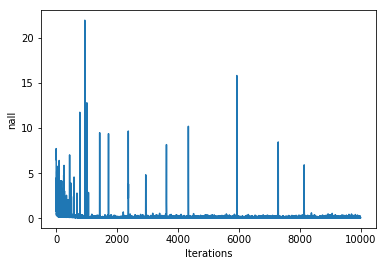

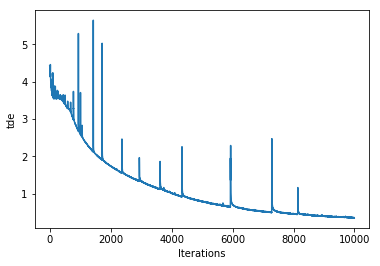

[('sigmas', (-2.0959744, -1.662284, 0.0)), ('ntll', 0.1325919), ('loss', -1.1685767), ('nall', 0.060275353), ('tde', 0.35012594)]
[('sigmas', (-2.0990236, -1.6675519, 0.0)), ('ntll', 0.1316326), ('loss', -1.2600379), ('nall', 0.053408615), ('tde', 0.34331864)]
[('sigmas', (-2.103715, -1.6617619, 0.0)), ('ntll', 0.13267088), ('loss', -1.1509807), ('nall', 0.065220915), ('tde', 0.34523022)]
[('sigmas', (-2.10211, -1.6630137, 0.0)), ('ntll', 0.13262092), ('loss', -0.012763262), ('nall', 0.20466399), ('tde', 0.34447733)]
[('sigmas', (-2.106328, -1.6687771, 0.0)), ('ntll', 0.13212748), ('loss', -1.332416), ('nall', 0.045731876), ('tde', 0.34145963)]
[('sigmas', (-2.1088414, -1.6638502, 0.0)), ('ntll', 0.13222794), ('loss', -1.3013182), ('nall', 0.050747026), ('tde', 0.33879346)]
[('sigmas', (-2.1087844, -1.6679868, 0.0)), ('ntll', 0.13255683), ('loss', -1.1412377), ('nall', 0.0713039), ('tde', 0.33634204)]
[('sigmas', (-2.111352, -1.6647495, 0.0)), ('ntll', 0.1320509), ('loss', -0.08078241)

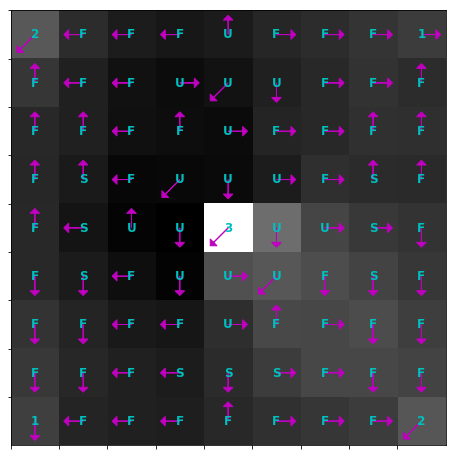

[[0.7874892  0.1104352  0.00001988 0.10205573 0.        ]
 [0.11059406 0.78852195 0.09965299 0.001231   0.        ]
 [0.00189992 0.14709684 0.7862251  0.06477817 0.        ]
 [0.09597755 0.00002133 0.08784233 0.81605977 0.00009905]
 [0.00000283 0.         0.00000001 0.00000562 0.99999154]
 [0.54210675 0.00005164 0.         0.45784163 0.        ]
 [0.5405003  0.00018644 0.00000066 0.45931262 0.        ]
 [0.52160573 0.00001322 0.00345176 0.47492933 0.        ]
 [0.53628844 0.         0.00014168 0.46352112 0.00004876]
 [0.00002171 0.         0.         0.00000721 0.99997103]]


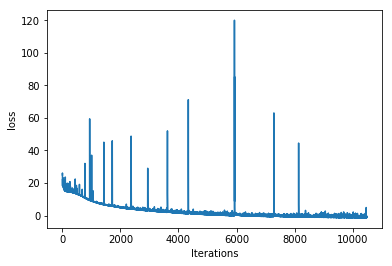

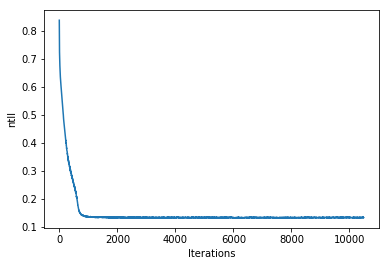

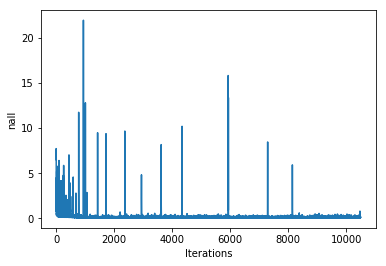

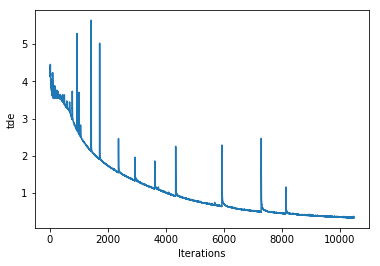

[('sigmas', (-2.110222, -1.661808, 0.0)), ('ntll', 0.13214305), ('loss', -1.2733657), ('nall', 0.05744264), ('tde', 0.3321298)]
[('sigmas', (-2.1134315, -1.6603247, 0.0)), ('ntll', 0.13238065), ('loss', -1.0103736), ('nall', 0.08570363), ('tde', 0.33939782)]
[('sigmas', (-2.114622, -1.6598778, 0.0)), ('ntll', 0.13210064), ('loss', -1.4392173), ('nall', 0.040557005), ('tde', 0.32613385)]
[('sigmas', (-2.1145806, -1.6591198, 0.0)), ('ntll', 0.13237938), ('loss', -0.91586566), ('nall', 0.10483216), ('tde', 0.32339302)]
[('sigmas', (-2.111164, -1.658248, 0.0)), ('ntll', 0.13171817), ('loss', -0.55721164), ('nall', 0.14647754), ('tde', 0.32776922)]
[('sigmas', (-2.1131637, -1.6609415, 0.0)), ('ntll', 0.13217008), ('loss', -1.4863224), ('nall', 0.03603584), ('tde', 0.32345757)]
[('sigmas', (-2.1137238, -1.6591195, 0.0)), ('ntll', 0.13270335), ('loss', 1.2161064), ('nall', 0.3594092), ('tde', 0.32902056)]
[('sigmas', (-2.1144607, -1.662896, 0.0)), ('ntll', 0.13194983), ('loss', -0.61897874), 

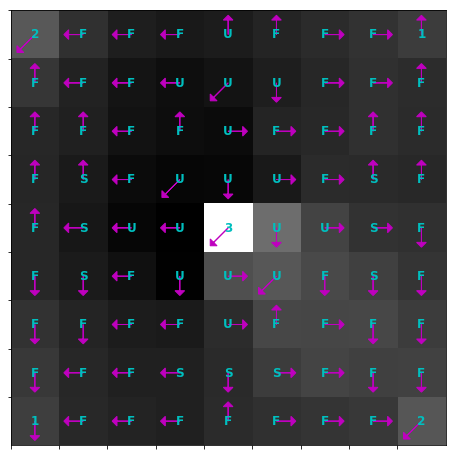

[[0.78546447 0.11013639 0.0000175  0.1043817  0.        ]
 [0.11031057 0.7961836  0.09230617 0.00119956 0.        ]
 [0.00195091 0.16464514 0.76314396 0.07026004 0.        ]
 [0.09593432 0.00002337 0.08352789 0.82043713 0.0000773 ]
 [0.00000338 0.         0.00000001 0.00000642 0.9999902 ]
 [0.5572601  0.00008635 0.         0.44265357 0.        ]
 [0.55128133 0.00035283 0.00000121 0.44836468 0.        ]
 [0.51811266 0.00003164 0.00799041 0.4738653  0.        ]
 [0.506707   0.         0.0002197  0.49303722 0.00003604]
 [0.00002632 0.         0.         0.00000914 0.9999645 ]]


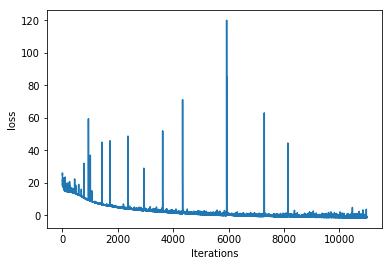

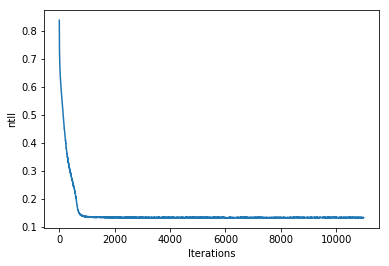

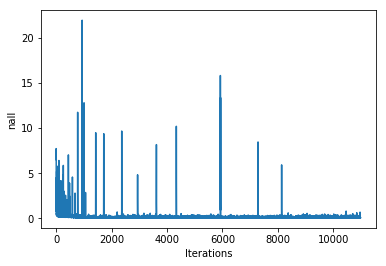

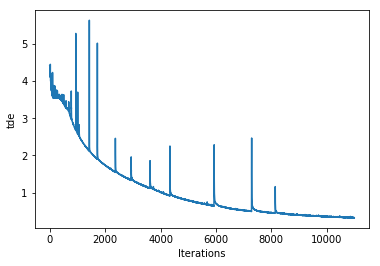

[('sigmas', (-2.1157217, -1.6609389, 0.0)), ('ntll', 0.13292384), ('loss', -1.4090083), ('nall', 0.04856459), ('tde', 0.3162592)]
[('sigmas', (-1.9986416, -1.6613724, 0.0)), ('ntll', 0.13354594), ('loss', -0.90537643), ('nall', 0.05722702), ('tde', 0.40725848)]
[('sigmas', (-2.0046434, -1.6617836, 0.0)), ('ntll', 0.13260637), ('loss', -1.0250893), ('nall', 0.0727984), ('tde', 0.35056487)]
[('sigmas', (-2.009413, -1.6636891, 0.0)), ('ntll', 0.13256094), ('loss', -0.5673187), ('nall', 0.1442369), ('tde', 0.33254334)]
[('sigmas', (-2.0153391, -1.6596891, 0.0)), ('ntll', 0.13275158), ('loss', -0.3932686), ('nall', 0.16942105), ('tde', 0.3281457)]
[('sigmas', (-2.0221221, -1.664247, 0.0)), ('ntll', 0.13229583), ('loss', -0.7128918), ('nall', 0.13078864), ('tde', 0.32167736)]
[('sigmas', (-2.0301278, -1.6617464, 0.0)), ('ntll', 0.13221487), ('loss', -0.6852126), ('nall', 0.13704161), ('tde', 0.31662676)]
[('sigmas', (-2.0377479, -1.6588265, 0.0)), ('ntll', 0.13315484), ('loss', -1.0345354), 

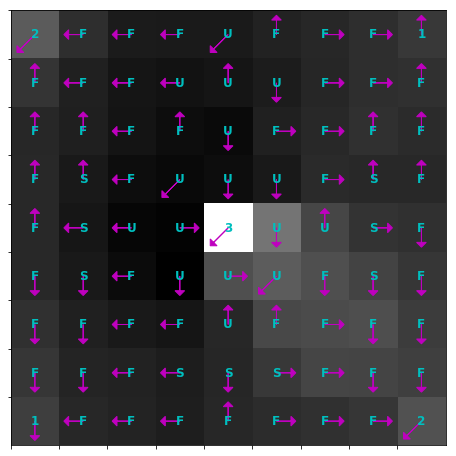

[[0.7900531  0.11449308 0.00001711 0.09543662 0.        ]
 [0.1049112  0.8000492  0.09396944 0.00107015 0.        ]
 [0.00179608 0.15846166 0.7725448  0.06719749 0.        ]
 [0.10052639 0.00002024 0.08534095 0.8140229  0.00008944]
 [0.00000264 0.         0.         0.00000452 0.99999285]
 [0.5711266  0.00021519 0.         0.4286582  0.        ]
 [0.5807987  0.00097489 0.00000272 0.4182237  0.        ]
 [0.5331997  0.00009234 0.02076226 0.4459457  0.        ]
 [0.5577326  0.         0.00038434 0.44184908 0.00003398]
 [0.00002625 0.         0.         0.00000722 0.9999665 ]]


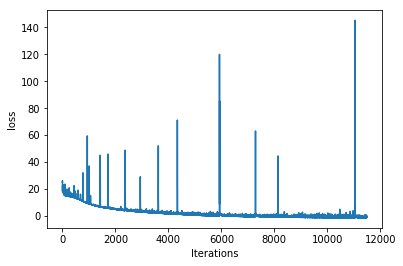

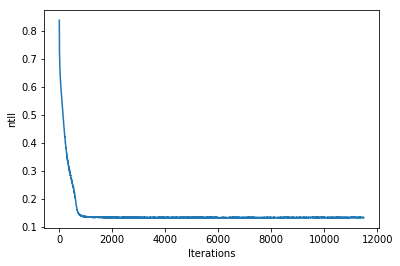

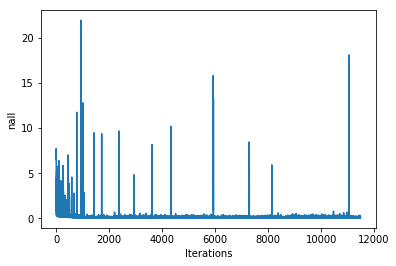

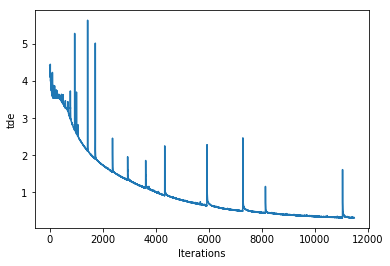

[('sigmas', (-2.0539947, -1.6629977, 0.0)), ('ntll', 0.13196848), ('loss', -1.3339887), ('nall', 0.05890406), ('tde', 0.30686605)]
[('sigmas', (-2.0597703, -1.6629789, 0.0)), ('ntll', 0.13272631), ('loss', -1.2552509), ('nall', 0.067442134), ('tde', 0.30958483)]
[('sigmas', (-2.0650055, -1.6640301, 0.0)), ('ntll', 0.13257602), ('loss', -0.6674259), ('nall', 0.14485753), ('tde', 0.30482116)]
[('sigmas', (-2.0700471, -1.6595074, 0.0)), ('ntll', 0.13244317), ('loss', -1.2378788), ('nall', 0.071587965), ('tde', 0.3070276)]
[('sigmas', (-2.0739787, -1.6603383, 0.0)), ('ntll', 0.13212131), ('loss', -1.3329811), ('nall', 0.061950114), ('tde', 0.30333316)]
[('sigmas', (-2.0739496, -1.6557072, 0.0)), ('ntll', 0.13348056), ('loss', -1.2526917), ('nall', 0.068665124), ('tde', 0.30791098)]
[('sigmas', (-2.0779305, -1.6596413, 0.0)), ('ntll', 0.132783), ('loss', -0.947068), ('nall', 0.11094708), ('tde', 0.3015427)]
[('sigmas', (-2.0811555, -1.6582294, 0.0)), ('ntll', 0.13280076), ('loss', -1.363916

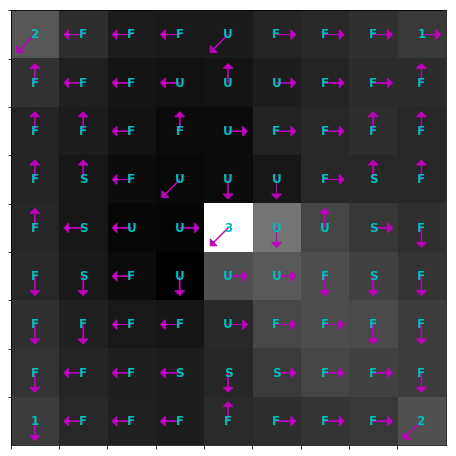

[[0.7798131  0.11568216 0.00001527 0.10448949 0.        ]
 [0.10853694 0.794735   0.09565499 0.00107303 0.        ]
 [0.00173886 0.15665829 0.77859503 0.06300775 0.        ]
 [0.10731314 0.00002307 0.10002545 0.79255825 0.00008011]
 [0.00000294 0.         0.00000001 0.00000424 0.99999285]
 [0.57807565 0.00055403 0.         0.42137033 0.        ]
 [0.58709335 0.00405688 0.00000363 0.4088461  0.        ]
 [0.5395556  0.00036747 0.02935398 0.43072295 0.        ]
 [0.5649705  0.         0.00069089 0.43432942 0.00000921]
 [0.00009195 0.         0.         0.00002313 0.99988496]]


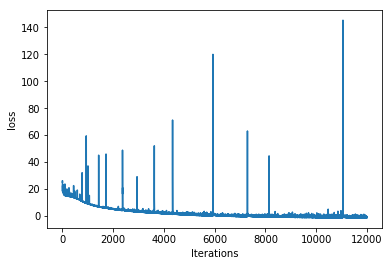

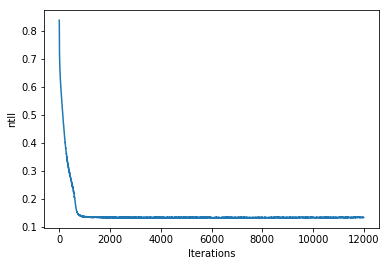

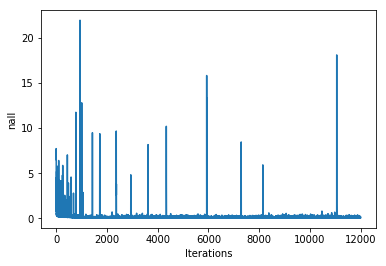

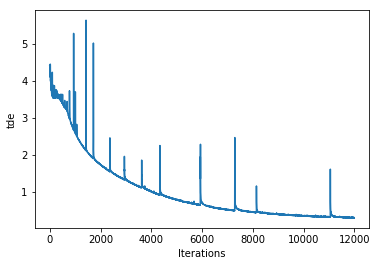

[('sigmas', (-2.0919216, -1.6568658, 0.0)), ('ntll', 0.13263474), ('loss', -0.9722247), ('nall', 0.10805961), ('tde', 0.30146128)]
[('sigmas', (-2.0941803, -1.6560943, 0.0)), ('ntll', 0.1329266), ('loss', -0.86476064), ('nall', 0.12318263), ('tde', 0.2972609)]
[('sigmas', (-2.1005023, -1.6556336, 0.0)), ('ntll', 0.13260345), ('loss', -1.5136824), ('nall', 0.045758113), ('tde', 0.2935583)]
[('sigmas', (-2.1028488, -1.6599107, 0.0)), ('ntll', 0.13226587), ('loss', -1.4050605), ('nall', 0.05773127), ('tde', 0.29733637)]
[('sigmas', (-2.1056123, -1.6615545, 0.0)), ('ntll', 0.13323481), ('loss', -1.0559411), ('nall', 0.10246605), ('tde', 0.29198694)]
[('sigmas', (-2.1127753, -1.6607693, 0.0)), ('ntll', 0.13305011), ('loss', -1.1225781), ('nall', 0.0962108), ('tde', 0.2887252)]
[('sigmas', (-2.1157405, -1.663556, 0.0)), ('ntll', 0.13222468), ('loss', -0.8591571), ('nall', 0.1293124), ('tde', 0.28737777)]
[('sigmas', (-2.1203716, -1.6635102, 0.0)), ('ntll', 0.13325228), ('loss', -1.4807365), 

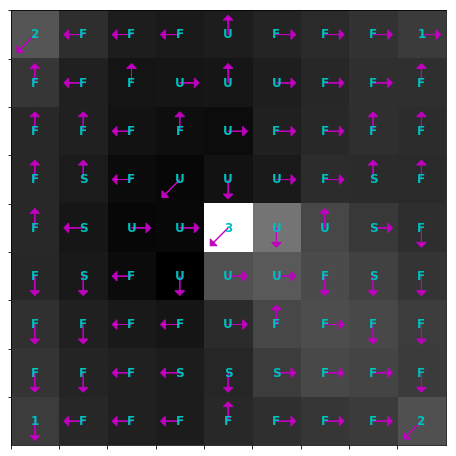

[[0.77749527 0.12429429 0.00001102 0.09819944 0.        ]
 [0.10339639 0.80002576 0.09559138 0.00098643 0.        ]
 [0.00180021 0.15528794 0.7803155  0.06259637 0.        ]
 [0.12744822 0.00004224 0.09411171 0.77828616 0.00011172]
 [0.00000218 0.         0.         0.0000023  0.99999547]
 [0.567196   0.00523488 0.         0.42756912 0.        ]
 [0.5157692  0.10437824 0.00000167 0.37985086 0.        ]
 [0.49309313 0.05835716 0.02987323 0.4186764  0.        ]
 [0.55961263 0.00000159 0.00184061 0.4385449  0.00000024]
 [0.0028365  0.         0.00000003 0.00072443 0.99643904]]


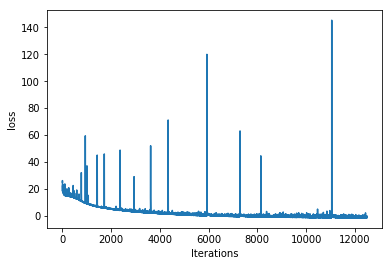

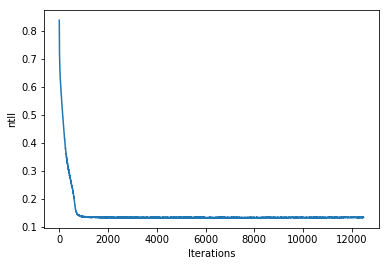

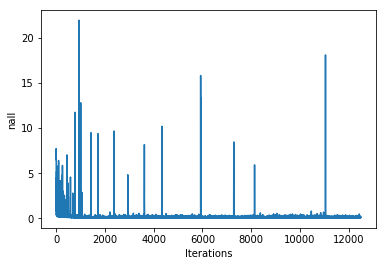

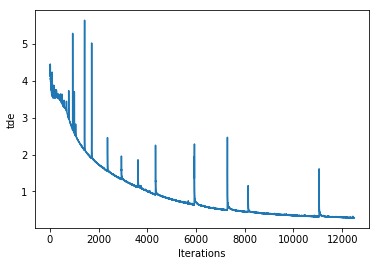

[('sigmas', (-2.1243804, -1.661639, 0.0)), ('ntll', 0.13290688), ('loss', -1.5019913), ('nall', 0.053482767), ('tde', 0.2840886)]
[('sigmas', (-2.126057, -1.6631322, 0.0)), ('ntll', 0.13256703), ('loss', -1.0450964), ('nall', 0.10469069), ('tde', 0.29180074)]
[('sigmas', (-2.1308382, -1.6620681, 0.0)), ('ntll', 0.1327182), ('loss', -1.127449), ('nall', 0.09913707), ('tde', 0.2827703)]
[('sigmas', (-2.1338131, -1.6571687, 0.0)), ('ntll', 0.133321), ('loss', -1.4048071), ('nall', 0.065092), ('tde', 0.28428683)]
[('sigmas', (-2.1337807, -1.6566118, 0.0)), ('ntll', 0.13244875), ('loss', -1.6233077), ('nall', 0.041769724), ('tde', 0.2800084)]
[('sigmas', (-2.134353, -1.6566938, 0.0)), ('ntll', 0.1331742), ('loss', -1.0049055), ('nall', 0.11427835), ('tde', 0.28055406)]
[('sigmas', (-2.137004, -1.6598647, 0.0)), ('ntll', 0.13212939), ('loss', -0.898926), ('nall', 0.12656523), ('tde', 0.28265294)]
[('sigmas', (-2.1375537, -1.6598682, 0.0)), ('ntll', 0.1319981), ('loss', -1.050221), ('nall', 0

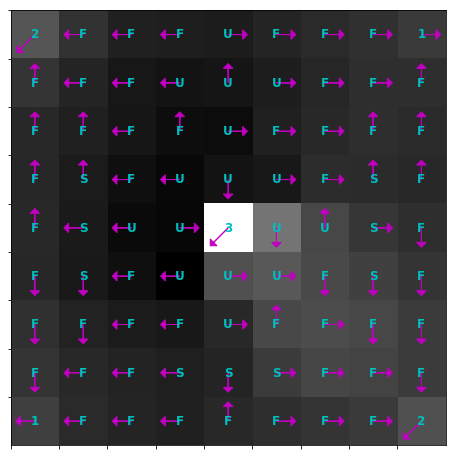

[[0.78317875 0.11490429 0.00000958 0.10190738 0.        ]
 [0.10862038 0.79182786 0.09851041 0.00104133 0.        ]
 [0.00163397 0.15138438 0.7809174  0.06606422 0.        ]
 [0.10916796 0.00004059 0.0994936  0.7912157  0.00008217]
 [0.00000234 0.         0.         0.00000291 0.99999475]
 [0.56370133 0.00650252 0.         0.42979616 0.        ]
 [0.51947993 0.10549045 0.00000107 0.37502852 0.        ]
 [0.49405777 0.07064309 0.02472142 0.4105777  0.        ]
 [0.5562243  0.00000242 0.00238359 0.44138908 0.00000054]
 [0.0011314  0.         0.00000002 0.00030737 0.9985612 ]]


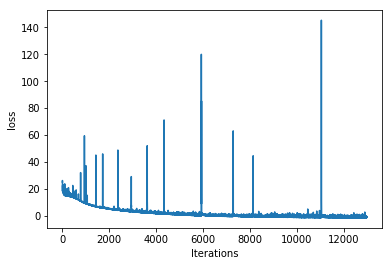

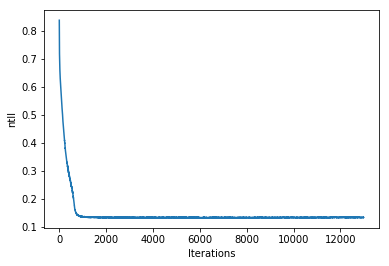

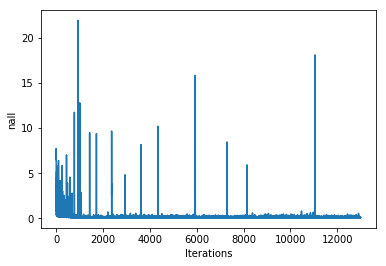

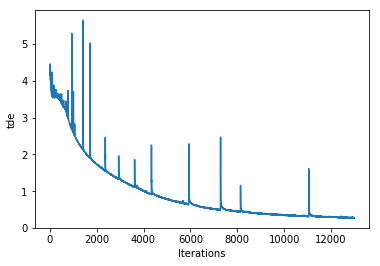

[('sigmas', (-2.1406507, -1.6605477, 0.0)), ('ntll', 0.13248338), ('loss', -1.6527724), ('nall', 0.040851343), ('tde', 0.27595833)]
[('sigmas', (-2.1390014, -1.6638871, 0.0)), ('ntll', 0.13291775), ('loss', -0.5136819), ('nall', 0.17361593), ('tde', 0.27831575)]
[('sigmas', (-2.1422718, -1.6602397, 0.0)), ('ntll', 0.13323395), ('loss', -1.6578395), ('nall', 0.041884948), ('tde', 0.27174425)]
[('sigmas', (-2.1420534, -1.6583942, 0.0)), ('ntll', 0.1330544), ('loss', -0.60031295), ('nall', 0.16215387), ('tde', 0.28010827)]
[('sigmas', (-2.145677, -1.6590601, 0.0)), ('ntll', 0.13281582), ('loss', -1.2443299), ('nall', 0.09129376), ('tde', 0.27054513)]
[('sigmas', (-2.1447709, -1.6614069, 0.0)), ('ntll', 0.13244976), ('loss', -1.3538175), ('nall', 0.07308818), ('tde', 0.28265148)]
[('sigmas', (-2.1469676, -1.6603614, 0.0)), ('ntll', 0.13239394), ('loss', -0.3855405), ('nall', 0.1903909), ('tde', 0.27392647)]
[('sigmas', (-2.1456735, -1.6596987, 0.0)), ('ntll', 0.13358869), ('loss', 1.527915

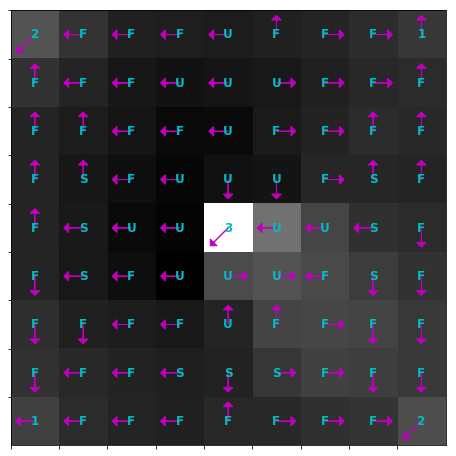

[[0.77965075 0.11644758 0.0000081  0.10389356 0.        ]
 [0.10323749 0.8037711  0.09203015 0.00096124 0.        ]
 [0.00151373 0.15804096 0.77405626 0.06638904 0.        ]
 [0.09996925 0.00003331 0.08942485 0.8104965  0.0000761 ]
 [0.00000203 0.         0.         0.00000295 0.999995  ]
 [0.55916196 0.00921204 0.         0.43162602 0.        ]
 [0.51276636 0.11509949 0.00000087 0.3721333  0.        ]
 [0.49002054 0.07689286 0.02394141 0.40914518 0.        ]
 [0.5467583  0.00000265 0.00300674 0.4502314  0.00000088]
 [0.00057655 0.         0.00000001 0.00018348 0.9992399 ]]


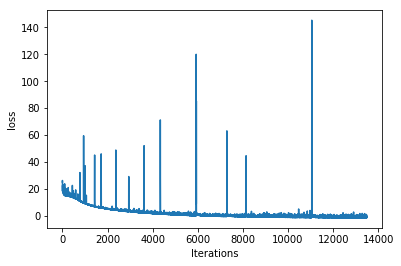

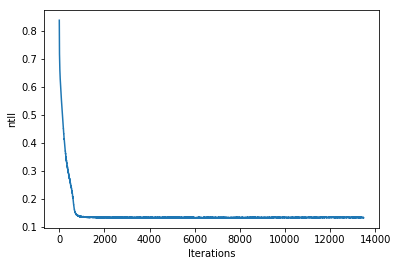

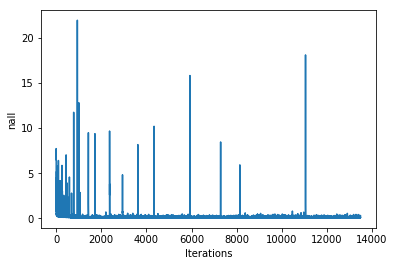

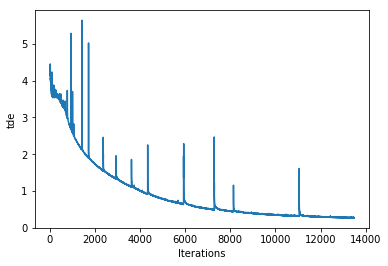

[('sigmas', (-2.1388159, -1.6648176, 0.0)), ('ntll', 0.13261081), ('loss', -0.42898846), ('nall', 0.18472774), ('tde', 0.2764029)]
[('sigmas', (-2.1357567, -1.664457, 0.0)), ('ntll', 0.13271706), ('loss', -0.7589853), ('nall', 0.1459824), ('tde', 0.27614895)]
[('sigmas', (-1.9558672, -1.6620959, 0.0)), ('ntll', 0.13226548), ('loss', -0.63397765), ('nall', 0.12855145), ('tde', 0.34450898)]
[('sigmas', (-1.9618198, -1.6644104, 0.0)), ('ntll', 0.1317803), ('loss', -0.78936195), ('nall', 0.12607582), ('tde', 0.31101185)]
[('sigmas', (-1.9721435, -1.6674191, 0.0)), ('ntll', 0.13199574), ('loss', -1.0797222), ('nall', 0.09758666), ('tde', 0.2898001)]
[('sigmas', (-1.9799689, -1.6619208, 0.0)), ('ntll', 0.1329289), ('loss', -1.4061084), ('nall', 0.055479247), ('tde', 0.28337833)]
[('sigmas', (-1.9894304, -1.6587601, 0.0)), ('ntll', 0.1325275), ('loss', -1.3696752), ('nall', 0.06280232), ('tde', 0.28080124)]
[('sigmas', (-1.996341, -1.6594313, 0.0)), ('ntll', 0.13257226), ('loss', -1.5735822),

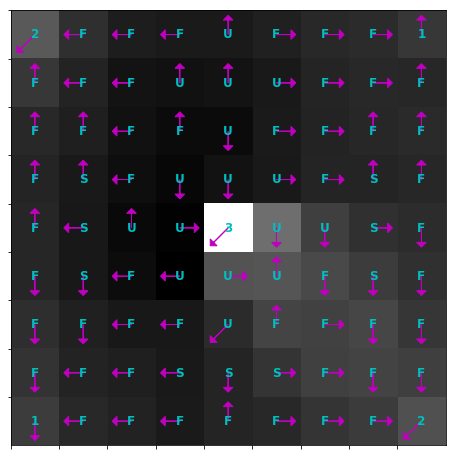

[[0.7913321  0.11393432 0.00000692 0.09472667 0.        ]
 [0.11153165 0.79786754 0.08969712 0.00090366 0.        ]
 [0.00165946 0.16821353 0.7641718  0.06595527 0.        ]
 [0.10510591 0.00003709 0.09290643 0.80189097 0.00005955]
 [0.00000257 0.         0.         0.00000345 0.9999939 ]
 [0.5511064  0.01067749 0.         0.43821615 0.        ]
 [0.50175375 0.10743914 0.00000056 0.39080665 0.        ]
 [0.46988478 0.09224998 0.02104287 0.41682234 0.        ]
 [0.5257541  0.00000479 0.00513143 0.4691089  0.00000083]
 [0.0005493  0.         0.00000002 0.00018944 0.9992612 ]]


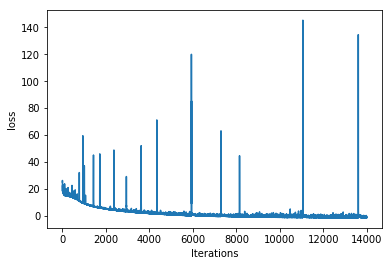

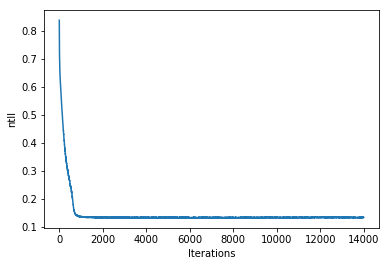

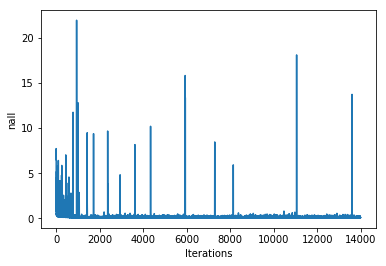

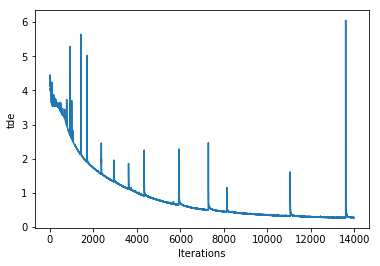

[('sigmas', (-2.0211928, -1.6559206, 0.0)), ('ntll', 0.13333158), ('loss', -1.049223), ('nall', 0.11252259), ('tde', 0.27006724)]
[('sigmas', (-2.0301657, -1.6541616, 0.0)), ('ntll', 0.13218679), ('loss', -0.8151603), ('nall', 0.14253135), ('tde', 0.27314422)]
[('sigmas', (-2.0323207, -1.6570556, 0.0)), ('ntll', 0.13269114), ('loss', -0.095762014), ('nall', 0.23656884), ('tde', 0.27309036)]
[('sigmas', (-2.0384943, -1.658914, 0.0)), ('ntll', 0.13339184), ('loss', -1.577455), ('nall', 0.046771184), ('tde', 0.26500198)]
[('sigmas', (-2.046159, -1.6569672, 0.0)), ('ntll', 0.13243973), ('loss', -1.5048366), ('nall', 0.057395864), ('tde', 0.26493025)]
[('sigmas', (-2.0480416, -1.6586661, 0.0)), ('ntll', 0.1320425), ('loss', -1.3814042), ('nall', 0.07344526), ('tde', 0.26559436)]
[('sigmas', (-2.0541606, -1.6578091, 0.0)), ('ntll', 0.13248469), ('loss', 0.31491852), ('nall', 0.289909), ('tde', 0.26756534)]
[('sigmas', (-2.0598514, -1.6609156, 0.0)), ('ntll', 0.13251781), ('loss', -0.96861434

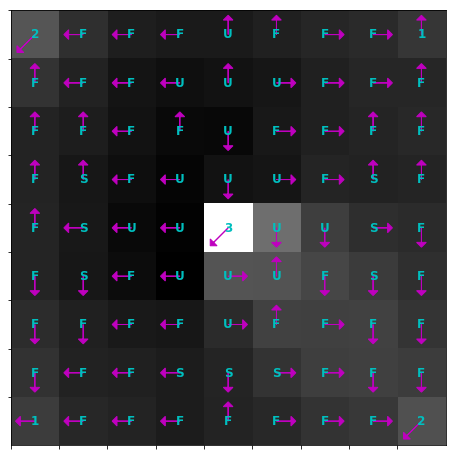

[[0.79583305 0.10750484 0.00000564 0.09665652 0.        ]
 [0.11053935 0.7953985  0.09315655 0.00090564 0.        ]
 [0.00157862 0.16217664 0.7701932  0.06605146 0.        ]
 [0.10627757 0.00002695 0.08703101 0.8066005  0.00006397]
 [0.00000218 0.         0.         0.0000028  0.999995  ]
 [0.5460457  0.01433928 0.         0.43961492 0.        ]
 [0.49686378 0.11511193 0.00000039 0.38802385 0.        ]
 [0.46243897 0.09286923 0.02054922 0.4241425  0.        ]
 [0.50775427 0.00000691 0.01278075 0.47945732 0.0000007 ]
 [0.00052955 0.         0.00000005 0.000207   0.99926335]]


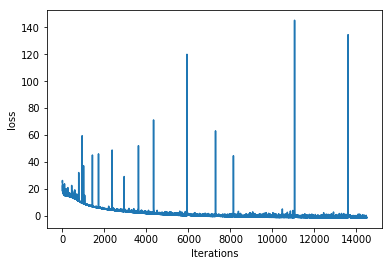

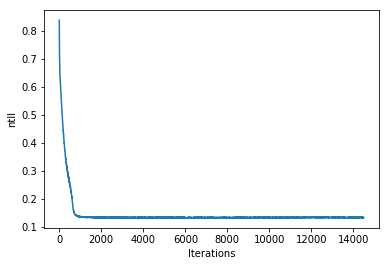

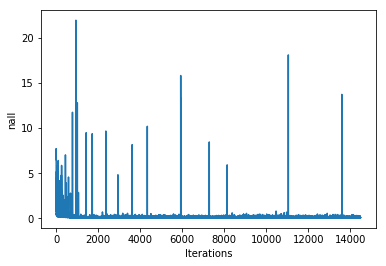

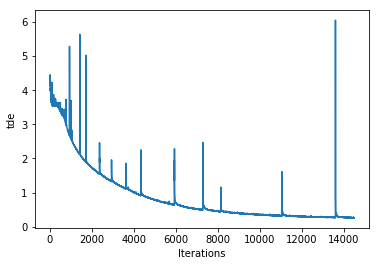

[('sigmas', (-2.0769339, -1.6608671, 0.0)), ('ntll', 0.13241714), ('loss', -1.7013478), ('nall', 0.037625037), ('tde', 0.2597949)]
[('sigmas', (-2.0803702, -1.6628903, 0.0)), ('ntll', 0.13229366), ('loss', -0.85673666), ('nall', 0.13806038), ('tde', 0.27080676)]
[('sigmas', (-2.0828846, -1.657435, 0.0)), ('ntll', 0.13209437), ('loss', -1.5910678), ('nall', 0.05121249), ('tde', 0.26129833)]
[('sigmas', (-2.0867376, -1.6613743, 0.0)), ('ntll', 0.13267654), ('loss', -1.5544074), ('nall', 0.05830626), ('tde', 0.25627297)]
[('sigmas', (-2.091642, -1.6589907, 0.0)), ('ntll', 0.13259606), ('loss', -1.3640027), ('nall', 0.08085618), ('tde', 0.25879502)]
[('sigmas', (-2.0960052, -1.6558849, 0.0)), ('ntll', 0.13254419), ('loss', -0.6635637), ('nall', 0.16296044), ('tde', 0.26716027)]
[('sigmas', (-2.0991535, -1.6567745, 0.0)), ('ntll', 0.13287711), ('loss', -1.3690963), ('nall', 0.079400465), ('tde', 0.26059783)]
[('sigmas', (-2.0997581, -1.6579571, 0.0)), ('ntll', 0.1323968), ('loss', -1.671027

In [52]:
# Generally I just run this for a bit, then interrupt and switch the update method......................

i = 0
while i < n_training_iters:
    demo_batch = sample_batch(nn_rollouts, train_idxes, batch_size)
    t = len(full_train_logs['loss_evals'])
    train_log = compute_batch_loss(demo_batch, constraints, step=True, update=update, t=t, true_qs=true_qs)        
    if i % 20 == 0:
        val_log = compute_batch_loss(val_demo_batch, constraints, step=False, update=update, t=t, true_qs=true_qs)
        for k, v in train_log.items():
            full_train_logs['%s_evals' % k].append(v)
        for k, v in val_log.items():
            if 'val_%s_evals' % k in full_train_logs:
                full_train_logs['val_%s_evals' % k].append(v)    
    
    if i % 1000 == 0:
#         print(t, val_log['loss'])
          print([(key,val_log[key]) for key in val_log.keys()])
    if i % 10000 == 0:
        q_vals = sess.run([constraint_q_ts], feed_dict={constraint_obs_t_feats_ph:states})[0]
        plot_values(mdp, q_vals)
        plt.show()
        adt_probs = sess.run([adt_pred_dir], feed_dict={demo_tile_t_ph:adt_samples[:,0][np.newaxis].T,
                                                demo_act_t_ph:adt_samples[:,1][np.newaxis].T})[0]
        print(softmax(adt_probs))
        
        for k in ['val_loss_evals','val_ntll_evals','val_nall_evals','val_tde_evals']:
            if len(full_train_logs[k]) > 0:
                plt.xlabel('Iterations')
                plt.ylabel(k.split('_')[1])
                plt.plot(full_train_logs[k][10:])
                plt.show()
    i += 1

## Testing Training Results

In [50]:
# Sample full dynamics model
adt_probs = sess.run([adt_pred_dir], feed_dict={demo_tile_t_ph:adt_samples[:,0][np.newaxis].T,
                                                demo_act_t_ph:adt_samples[:,1][np.newaxis].T})[0]

In [ ]:
# Print learned dynamics
softmax(adt_probs)

In [ ]:
# Sample full q-fn model
q_vals = sess.run([constraint_q_ts], feed_dict={constraint_obs_t_feats_ph:states})[0]
# q_vals = sess.run([demo_q_t], feed_dict={demo_obs_t_feats_ph:states})[0]

In [ ]:
# Plot learned q-values and true q-values
plot_values(mdp, q_vals)
plot_values(mdp, Qs)

In [ ]:
q_vals - Qs

In [ ]:
# More comprehensive debugging stuff

test_constraint_adt_pred_probs =  tf.placeholder(tf.float32, [None, n_dirs], name="tpp")
test_constraint_q_t_ph = tf.placeholder(tf.float32, [None], name="tcq")
test_constraint_q_tp1_ph = tf.placeholder(tf.float32, [None, n_dirs, n_act_dim], name="tcqp1")
test_constraint_v_tp1 = tf.reduce_logsumexp(test_constraint_q_tp1_ph, axis=2) #- np.log(5) 
test_adt_V = tf.multiply(test_constraint_v_tp1, test_constraint_adt_pred_probs)
test_adt_target = constraint_rew_t_ph + gamma * tf.reduce_sum(test_adt_V, axis=1)
indiv_errs = test_constraint_q_t_ph - test_adt_target
test_adt_td_err = tf.reduce_mean((test_constraint_q_t_ph - test_adt_target)**2)

In [ ]:
# More comprehensive debugging stuff

sa = np.transpose([np.tile(np.arange(mdp.nS), mdp.nA), np.repeat(np.arange(mdp.nA), mdp.nS)])
states, acts = sa[:,0], sa[:,1]

next_states = [[mdp.sd_to_sprime(s,d) for d in range(mdp.nD)] for s in states]
currQs = Qs[states,acts]
nextQs = Qs[next_states]

pred_probs = true_tps[acts,:,constraints[4].flatten()]

test_err, learned_err, targets = sess.run([test_adt_td_err, adt_td_err_sg, test_adt_target], feed_dict= {constraint_obs_t_feats_ph: constraints[0],
                                    constraint_act_t_ph: constraints[1],
                                    constraint_rew_t_ph: constraints[2],
                                    constraint_next_obs_t_feats_ph: constraints[3],
                                    constraint_tile_t_ph: constraints[4],
                                    constraint_batch_size_ph: constraints[0].shape[0],
                                    test_constraint_q_t_ph: currQs,
                                    test_constraint_q_tp1_ph: nextQs,
                                    test_constraint_adt_pred_probs: pred_probs})
print(test_err, learned_err)

In [ ]:
# Q-fn Model Storage
q_net_path = os.path.join(data_dir, 'adt_brsgt_q.tf')
save_tf_vars(sess, q_scope, q_net_path)

In [ ]:
# Dynamics Model Storage
invadt_path = os.path.join(data_dir, 'adt_brgst_invadt.tf')
save_tf_vars(sess, invadt_scope, invadt_path)

In [ ]:
# Training data Storage
pkl.dump(full_train_logs, open('adt_brsgt.pkl', 'wb'))

## Comparison Tests (NOT UPDATED)

In [ ]:
def demo_stats(mdp, demos):
    demo_rewards = []
    for i in range(len(demos)):
        demo_rewards += [np.array([mdp.rewards[obs[0][2]] for obs in demos[i]])]
#         for j in range(len(demo_rewards[i])):
#             print(demos[i][j][0], demo_rewards[i][j])
    
    discounted_demo_rewards = [np.power(gamma,np.arange(len(dr)))*dr for dr in demo_rewards]
    demo_rewards, discounted_demo_rewards = np.array(demo_rewards), np.array(discounted_demo_rewards)
    data = {"mean episode reward": np.mean(np.sum(demo_rewards, axis=1)),
            "sd episode reward": np.std(np.sum(demo_rewards, axis=1)),
            "mean discounted episode reward": np.mean(np.sum(discounted_demo_rewards, axis=1)),
            "sd discounted episode reward": np.std(np.sum(discounted_demo_rewards, axis=1))}
    return data
    
    

In [ ]:
SERD_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qs), 2000, demo_time_steps)
IDL_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qi), 2000, demo_time_steps)

In [ ]:
print(demo_stats(mdp, SERD_demos))

In [ ]:
print(demo_stats(mdp, IDL_demos))

In [ ]:
plot_values(mdp, Qs)

In [ ]:
plot_values(mdp, Qi)

In [ ]:
print(reward_map[5][0], Qi[2], Q[2])

### Transfer

In [ ]:
tile_map2 = [
        "2FFFFFFF1",
        "FFFFFFFFF",
        "FFFFUFFFF",
        "FFFUUUFSF",
        "FFUU3UUFF",
        "FSFUUUFSF",
        "FSFFUFFSF",
        "FFFSSSFFF",
        "1FFFFFFF2"
    ]
reward_map2, texture_map2 = build_reward_map(tile_map2, tile_rewards, goal_tile_rewards, tile_reward_modifier)
# reward_normalizer2 = (1-gamma)/(np.max(reward_map2))
# reward_map2 *= reward_normalizer2
# time_penalty *= reward_normalizer2
# temperature2 = 1/(reward_normalizer2)
# print(temperature2)
print(reward_map2)
print(texture_map2)

In [ ]:
mdp = MarsExplorerEnv(tile_map2, reward_map2, texture_map2, trans_dict, time_penalty) 
nA = mdp.nA
nS = mdp.nS

In [ ]:

Tips = softmax(Ti_thetas,axis=1)
Ti = mdp.adt_trans_to_sas_trans(Tips)
Ri = mdp.rewards
Qit = tabsoftq_iter(Ri, Ti, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
Tips = softmax(Ti_thetas,axis=1)
Ti = mdp.adt_trans_to_sas_trans(Tips)
Ri = mdp.rewards
Qit = tabsoftq_iter(Ri, Ti, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
Tsps = softmax(Ts_thetas,axis=1)
Ts = mdp.adt_trans_to_sas_trans(Tips)
Rs = mdp.feature_map.dot(Rs_thetas)
Qst = tabsoftq_iter(Rs, Ts, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
IDL_trans_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qit), 1000, demo_time_steps)
SERD_trans_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qst), 1000, demo_time_steps)

In [ ]:
plot_mars(mdp,tabsoftq_gen_pol(Qit),Qs=Qit)

In [ ]:
print(demo_stats(mdp, IDL_trans_demos))

In [ ]:
print(demo_stats(mdp, SERD_trans_demos))

In [ ]:
plot_values(mdp, Qit)

In [ ]:
plot_values(mdp, Qst)

In [ ]:
Qtrue = tabsoftq_learn_Qs(mdp)
plot_values(mdp,Qtrue)

In [ ]:
mdp.get_possible_sprimes(np.array([[0,0],[0,1]]))

In [ ]:
i = 15
mdp.get_direction_moved(nn_rollouts[0][i][0],nn_rollouts[0][i+1][0])

In [ ]:
nn_rollouts[0][i], nn_rollouts[0][i+1]

In [ ]:
nn_rollouts[0][:30]